# 113th Congress as News Commentators on Twitter

### Note : [Blogged](http://talhaoz.com/?p=634) about this study.

In this project I am answering the following questions:

* Who are the most active news commentators among senators and congressmen ?
* Which news got the most attention by the politicians ?
* How many news (of 7376) are commentated by democrats and/or republicans...
* How many comments made on these news by each group ?
* What are the news with the highest difference of comment counts (of groups)?

The news and the curated tweets used in this study are scraped from theplazz.com approximately matching the duration of [113th US Congress](https://en.wikipedia.org/wiki/113th_United_States_Congress), i.e. between Jan 2013 - Jan 2015.

See [here](http://talhaoz.com/news/) for other iPython notebooks on this project.

Project (datasets and the source code) is available on [GitHub](https://github.com/oztalha/News-Commentary-Tweets-of-Elites)


In [1]:
cd ..

/Users/toz/Documents/workspace/News-Commentary-Tweets-of-Elites


In [2]:
import twitter
import pandas as pd
import numpy as np
import plotly.plotly as py
from plotly.graph_objs import *
from mykeys import tw
import networkx as nx
import itertools
from collections import Counter
%matplotlib inline

In [3]:
def oauth_login():
    """Twitter authorization """
    #tw is a dictionary, the only variable in mykeys.py
    auth = twitter.oauth.OAuth(tw['OAUTH_TOKEN'], tw['OAUTH_TOKEN_SECRET'],
             tw['CONSUMER_KEY'], tw['CONSUMER_SECRET'])
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api


def get_members(members):
    """Scrape only the interesting info from twitter json response """
    return [(m['id'],m['screen_name'],m['name'],m['location'],m['description'],
            m['created_at'], m['friends_count'],m['followers_count'],
            m['statuses_count'],m['favourites_count']) for m in members['users']]


def tw_to_pol(twitter_api,slug,owner_screen_name,group):
    """Get members of a twitter list with known political group into a dataframe """
    resp = twitter_api.lists.members(slug=slug,owner_screen_name=owner_screen_name,cursor=-1,count=5000)
    members = get_members(resp)
    df = pd.DataFrame(members,columns=header)
    df['party'] = group
    return df


def get_politicians():
    """Download 113th congress tweeps using public Twitter lists"""

    header = ['id','screen_name','name','location','description','created_at',
           'friends','followers','statuses','favorites']

    polists = [{'slug':'senaterepublicans', 'owner_screen_name':'Senate_GOPs', 'group':'gop'}, #62
               {'slug':'house-republicans', 'owner_screen_name':'HouseGOP', 'group':'gop'}, #260
               {'slug':'housegop', 'owner_screen_name':'GOPLeader', 'group':'gop'}, #237
               {'slug':'elected-democrats', 'owner_screen_name':'TheDemocrats', 'group':'dem'}, #259
               {'slug':'house-democrats', 'owner_screen_name':'DannyMariachi', 'group':'dem'}, #188
               {'slug':'senatedemocrats', 'owner_screen_name':'SenateDems', 'group':'dem'} #52
              ]
    
    twitter_api = oauth_login()

    df = pd.DataFrame(columns=header)
    for polist in polists:
        df = df.append(tw_to_pol(twitter_api,polist['slug'],polist['owner_screen_name'],polist['group']))
    df = df.drop_duplicates()
    df.to_csv('data/US-politicians.csv',encoding='utf-8',index=False)
    return df

In [3]:
# get twitter IDs of congressmen and senators
df = pd.read_csv('data/US-politicians.csv',encoding='utf-8')
gop = df[df['party']=='gop']
dem = df[df['party']=='dem']
dem_tweeps = set(dem.screen_name.values)
gop_tweeps = set(gop.screen_name.values)
# Principal Accounts of Members of the U.S. Senate (a mix of campaign and government accounts)
senate = pd.read_csv('data/US-senate.csv',encoding='utf-8')

In [4]:
# get commentary tweets of US newsmakers and opinion-shapers
tweets = pd.read_csv('data/US-tweets.csv',encoding='utf-8',parse_dates=['dt'])
tweets.twhandle = tweets.twhandle.str[1:]
#tweets.dt = pd.to_datetime(tweets.dt,unit='D')

In [5]:
# print politician counts curated at least once by theplazz.com
title = tweets.groupby(by=['title','dt'])['twhandle']
print (len(title),'news commentated between',tweets.dt.order().iloc[0].strftime('%d-%b-%Y'),
       'and',tweets.dt.order().iloc[-1].strftime('%d-%b-%Y'),'by')
tweepset = set(tweets.twhandle.unique())
senateset = set(senate.screen_name.values)
twcounts = pd.DataFrame(columns=['# of tweeps'])
twcounts.loc['senator'] = [len(senateset & tweepset)]
twcounts.loc['democrat'] = [len(dem_tweeps & tweepset)]
twcounts.loc['republican']= [len(gop_tweeps & tweepset)]
twcounts.loc['total'] = [len(tweepset)]
twcounts

7376 news commentated between 14-Jan-2013 and 09-Jan-2015 by


,# of tweeps
senator,44
democrat,36
republican,30
total,1442


In [6]:
# plot commentating activity of these politicians
tweeps = tweets.groupby(by='twhandle')['twtext'].count().order(ascending=False)
poltweeps = tweeps[tweeps.index.isin(df.screen_name)]
colors = ['blue' if x in dem_tweeps else 'red' for x in poltweeps.index]
data = Data([Bar(
        x=poltweeps.index,
        y=poltweeps.values,
        marker=Marker(color=colors)
        )])
layout = Layout(yaxis=YAxis(title='# of news commentated (Jan 2013 - Jan 2015)'),
                title="News counts commentated by 113th US Congress (curated by theplazz.com)")
fig = Figure(data=data, layout=layout)
py.iplot(fig,filename="113th US Congress as News Commentators")

In [7]:
# Stats: how many news are commentated by how many democrats and/or republicans...
demnews = title.apply(lambda g: len(dem_tweeps & set(g.values)))
gopnews = title.apply(lambda g: len(gop_tweeps & set(g.values)))
print (demnews.sum(),'comments made on',demnews[demnews>0].size,'news by democrats.')
print (gopnews.sum(),'comments made on',gopnews[gopnews>0].size,'news by republicans.')
dgtotl = (demnews + gopnews)
print ('News commentated by any member of either group:',(dgtotl[dgtotl>0].size))
# Number of comments by dems - number of comments by gops
dgdiff = (demnews - gopnews)
# Normalize the polarity
dgdiv = dgdiff/dgtotl
digdiv = dgdiv.order()[:dgtotl[dgtotl>0].size]
print ('News commentated by democrats only:',(digdiv[digdiv == 1].size))
print ('News commentated by republicans only:',(digdiv[digdiv == -1].size))
print ('News commentated by both of the parties:',(digdiv[(digdiv > -1) & (digdiv < 1)].size))

2829 comments made on 1239 news by democrats.
2109 comments made on 1183 news by republicans.
News commentated by any member of either group: 1916
News commentated by democrats only: 733
News commentated by republicans only: 677
News commentated by both of the parties: 506


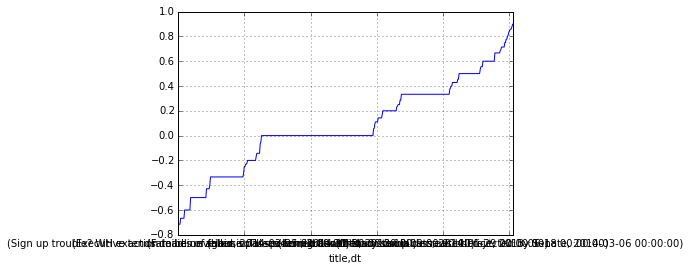

In [8]:
# commentator group polarity distribution of news
digdiv[(digdiv > -1) & (digdiv < 1)].plot();

In [9]:
data = Data([Bar(
        x=digdiv.index.get_level_values(0),
        y=digdiv[(digdiv > -1) & (digdiv < 1)]
        )])
layout = Layout(yaxis=YAxis(title='# of news commentated (Jan 2013 - Jan 2015)'),
                margin=Margin(l=150,r=150,b=150),
                title="News polarized by 113th US Congress (curated by theplazz.com)")
fig = Figure(data=data, layout=layout)
py.iplot(fig,filename="Polarity distribution of news")

In [10]:
# Which news got the most attention by the politicians ?
dgtotl.order(ascending=False).head(60)

title                                               dt        
A day to honor veterans’ courage, sacrifrice        2014-05-26    36
Apartheid resistance leader Mandela has died        2013-12-05    31
World marks 70th anniversary of D-Day               2014-06-06    24
US observes somber 9/11 anniversary                 2014-09-11    21
Senate passes 5-month UI extension                  2014-04-07    21
Dems’ attempt to raise minimum wage fails           2014-04-30    20
Shinseki resigns from VA following apology          2014-05-30    20
Deportation to focus on ‘felons not families’       2014-11-20    19
A reflection on rights on Constitution Day          2014-09-17    19
Dems push #EqualPay bill on Equal Pay Day           2014-04-08    19
Around the world, Jews welcome 5774                 2013-09-04    18
Remembering Rev. Dr. Martin Luther King Jr.         2014-01-20    18
4 dead after Fort Hood shooting incident            2014-04-02    18
Congress critters @work: #DontDoubleMyRa

In [11]:
# On which news the comment-count differences maximized?
dgdiff.order()

title                                             dt        
Republicans call Obama executive action illegal   2014-11-20    -9
Tweeps wish US’ 40th prez a happy birthday        2014-02-06    -9
Sign up trouble? WH extends deadline again        2014-03-25    -8
Britain’s Iron Lady dies of stroke at 87          2013-04-08    -8
Late filers beware: The taxman cometh             2014-04-15    -8
SCOTUS rules for prayer at public meetings        2014-05-05    -7
National Day of Prayer offers controversy, unity  2014-05-01    -6
GOP calls for ‘permanent delay’ of ObamaCare      2013-07-10    -6
WH may not cooperate with Benghazi probe          2014-05-05    -6
Repubs squelch short-term budget fix              2013-02-05    -6
Shinseki resigns from VA following apology        2014-05-30    -6
Boehner pressed for Obamacare alternative         2013-12-03    -5
Sudan detains Christian woman after release       2014-06-24    -5
214 days later: Mexican court frees Tahmooressi   2014-11-01    -5
O

In [19]:
#crate bipartite network for bpnet
G2=nx.Graph()
# add actors
for politician,color in list(zip(poltweeps.index.tolist(),colors)):
    G2.add_node(politician, color=color,bipartite=0)
# add events
for e in dgtotl.index.tolist():
    G2.add_node(e,bipartite=1)

In [20]:
def updateG2(group,G2,politicians):
    """ Create two-mode edges """
    actors = set(group.tolist()) #this can be extended, no weight on two-mode
    for actor in actors:
        if actor not in politicians:
            continue
        G2.add_edge(group.name, actor)

In [21]:
# add edges
title.apply(updateG2,G2,set(poltweeps.index))

# print number of nodes and edges
actors = events = 0
for n in G2.nodes(data=True):
    if n[1]['bipartite']==0:
        actors += 1
    else:
        events += 1
print ('actors:',actors,'\tevents:',events,'\tedges:',G2.number_of_edges())

actors: 66 	events: 7376 	edges: 4938


In [23]:
"""The Network File is text file with a binary rectangular matrix.
The number of rows for the matrix should be the same as the number of Actors(A),
and the number of columns is the number of Actors(P)."""
actors = [n[0] for n in G2.nodes(data=True) if n[1]['bipartite']==0]
events = [n[0] for n in G2.nodes(data=True) if n[1]['bipartite']==1]

M = np.matrix(np.zeros((len(events),len(actors))))
for i,event in enumerate(events):
    for j,actor in enumerate(actors):
        if G2.has_edge(actor, event):
            M[i,j]=1
np.savetxt("data/congress_2mode.txt", M, fmt='%d')

In [12]:
# let's create the actor network 
# vertices <- commentators
# edges (weighted) <- number of news commentated by vertices incident to the edge

G=nx.Graph()
# add vertices
for politician,color in list(zip(poltweeps.index.tolist(),colors)):
    G.add_node(politician, color=color)
# print(G.nodes(data=True))

In [13]:
def updateG(group,G,politicians):
    """ Create weighted edges """
    edges = itertools.combinations(group.tolist(), 2)
    for v1,v2 in edges:
        if v1 not in politicians or v2 not in politicians:
            continue
        if G.has_edge(v1, v2):
            G[v1][v2]['weight'] += 1
        else:
            G.add_edge(v1, v2, weight=1)

In [16]:
# add edges
title.apply(updateG,G,set(poltweeps.index))
# print number of nodes and edges
print (G.number_of_nodes(),G.number_of_edges())

66 1863


In [17]:
# Exporting to be read by Gephi for better visualization
# nx.write_gml(G,"data/theplazz_politics.gml")

# export for R-ergm
A = nx.to_numpy_matrix(G, weight='weight')
np.savetxt("data/congress_actors_weighted.txt", A, fmt='%d')

In [15]:
# network file for pnet
A = nx.to_numpy_matrix(G, weight=None)
np.savetxt("data/congress_actor.txt", A, fmt='%d')

In [22]:
#attribute file for pnet
party = [str(2) if n[1]['color']=='red' else str(1) for n in G.nodes(data=True)]
party.insert(0,'party')
with open('data/congress_attribute.txt','w') as w:
    w.write('\n'.join(party))

In [28]:
#attribute file for R-ergm
party = ['R' if n[1]['color']=='red' else 'D' for n in G.nodes(data=True)]
party.insert(0,'party')
with open('data/congress_attributes.txt','w') as w:
    w.write('\n'.join(party))

In [23]:
# 62 of the 65 monitored Congress members are found to be in the same group as their co-party members
# 3 congresspeople not in the same group as their co-party members are circled
from IPython.display import Image
Image(url='http://talhaoz.com/wp-content/uploads/2015/03/Modularity_Labeled.png')